# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [var_smoothing](#var_smoothing)
* [n_estimators](#n_estimators)
* [Discussion](#Discussion)

# Introduction

After rounds of feature engineering, visualization & exploration, and tuning various aspects of the classification pipeline, we are about to create our first prototype classifier using a bagged GaussianNB. In this notebook, we perform a grid search over var_smoothing using out-of-bag accuracy instead of cross validation. Fixing this var_smoothing to the best value observed, we perform a grid search for n_estimators of the bagging meta-classifier.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# classifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

# metrics
from sklearn.metrics import log_loss, roc_auc_score

# typing
from typing import Sequence

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.33 s


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location of pre-final features
FEATURES_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 110 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather(
        f"{FEATURES_FOLDER}/scaled_features_ready_for_selection.feather"
    ).set_index("id")
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
assert all(data.index == labels.index)
assert len(data) < 79000
y_true = labels.valence
gnb_features = ["spherical-LDA1", "spherical-LDA2"]
_ = gc_collect()

time: 155 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 78777 entries, 0 to 87363
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     78777 non-null  float64
 1   LDA2                     78777 non-null  float64
 2   ocLDA_neg                78777 non-null  float64
 3   ocLDA_neu                78777 non-null  float64
 4   ocLDA_pos                78777 non-null  float64
 5   ocSVM_sgdlinear_LDA1     78777 non-null  float64
 6   ocSVM_sgdlinear_LDA2     78777 non-null  float64
 7   ocSVM_sgdlinear_neg      78777 non-null  float64
 8   ocSVM_sgdlinear_neu      78777 non-null  float64
 9   ocSVM_sgdlinear_pos      78777 non-null  float64
 10  LDA-LOF_neg_30           78777 non-null  float64
 11  LDA-LOF_neu_30           78777 non-null  float64
 12  LDA-LOF_pos_30           78777 non-null  float64
 13  LDA-ocSVM_sgdlinear_neg  78777 non-null  float64
 14  LDA-ocSVM_sgdlinear_n

In [7]:
results = {"var_smoothing": [], "oob_score": [], "log_loss": [], "auroc": []}
_ = gc_collect()

time: 97.6 ms


# var_smoothing

In [8]:
def tune_var_smoothing(search_space: Sequence, outfile: str) -> None:
    """Run tuning procedure"""
    df = data.loc[:, gnb_features]
    make_gnb = lambda var_smoothing: BaggingClassifier(
        base_estimator=GaussianNB(var_smoothing=var_smoothing),
        n_estimators=50,
        oob_score=True,
        n_jobs=-1,
        random_state=SEED,
        # verbose=1,
    ).fit(df, y_true)
    for hp in tqdm(search_space):
        gnb = make_gnb(hp)
        results["var_smoothing"].append(hp)
        results["oob_score"].append(gnb.oob_score_)
        results["auroc"].append(
            roc_auc_score(y_true, y_pred := gnb.predict_proba(df), multi_class="ovo")
        )
        results["log_loss"].append(log_loss(y_true, y_pred))

    df = pd.DataFrame(results).sort_values(by="var_smoothing", ascending=True)
    print(df.sort_values(by="oob_score", ascending=False).head(10))
    print(df.sort_values(by="log_loss", ascending=True).head(10))
    print(df.sort_values(by="auroc", ascending=False).head(10))
    df.plot(x="var_smoothing")
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

    df.columns = df.columns.astype(str)
    df.reset_index(drop=True).to_feather(f"{DATA_OUT_FOLDER}/{outfile}.feather")


_ = gc_collect()

time: 122 ms


  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
21       0.087750   0.667390  0.784890  0.822666
48       0.024178   0.667352  0.802807  0.821832
22       0.089603   0.667327  0.784507  0.822687
40       0.024416   0.667327  0.802719  0.821836
42       0.089039   0.667327  0.784623  0.822681
41       0.012735   0.667289  0.807224  0.821657
19       0.028930   0.667276  0.801096  0.821903
33       0.011346   0.667251  0.807790  0.821635
3        0.014992   0.667238  0.806318  0.821692
14       0.110413   0.667200  0.780633  0.822915
    var_smoothing  oob_score  log_loss     auroc
37       0.274353   0.665093  0.769150  0.824251
49       0.269499   0.665105  0.769162  0.824220
6        0.269297   0.665105  0.769163  0.824219
8        0.269089   0.665131  0.769164  0.824218
13       0.287113   0.665143  0.769183  0.824331
39       0.289465   0.665181  0.769199  0.824345
32       0.292773   0.665143  0.769226  0.824365
18       0.293259   0.665143  0.769230  0.824368
26       0.259331   

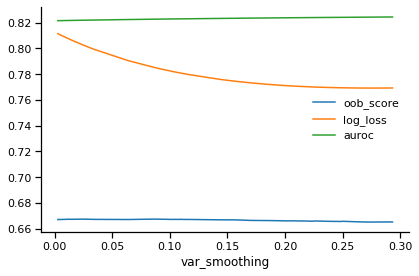

time: 1min 13s


In [9]:
tune_var_smoothing(
    search_space=np.random.uniform(0.0, 0.3, size=50), outfile="var_smoothing1"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
21       0.087750   0.667390  0.784890  0.822666
48       0.024178   0.667352  0.802807  0.821832
74       0.023798   0.667339  0.802946  0.821827
40       0.024416   0.667327  0.802719  0.821836
22       0.089603   0.667327  0.784507  0.822687
42       0.089039   0.667327  0.784623  0.822681
41       0.012735   0.667289  0.807224  0.821657
19       0.028930   0.667276  0.801096  0.821903
71       0.011304   0.667251  0.807807  0.821634
33       0.011346   0.667251  0.807790  0.821635
    var_smoothing  oob_score  log_loss     auroc
37       0.274353   0.665093  0.769150  0.824251
49       0.269499   0.665105  0.769162  0.824220
6        0.269297   0.665105  0.769163  0.824219
8        0.269089   0.665131  0.769164  0.824218
13       0.287113   0.665143  0.769183  0.824331
39       0.289465   0.665181  0.769199  0.824345
32       0.292773   0.665143  0.769226  0.824365
18       0.293259   0.665143  0.769230  0.824368
26       0.259331   

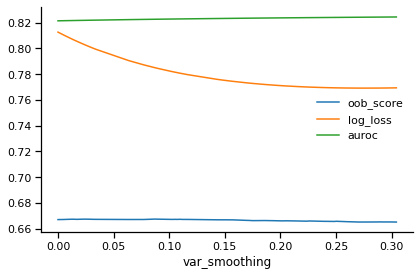

time: 1min 8s


In [10]:
tune_var_smoothing(
    search_space=loguniform.rvs(1e-11, 0.4, size=50), outfile="var_smoothing2"
)

  0%|          | 0/50 [00:00<?, ?it/s]

    var_smoothing  oob_score  log_loss     auroc
21       0.087750   0.667390  0.784890  0.822666
48       0.024178   0.667352  0.802807  0.821832
74       0.023798   0.667339  0.802946  0.821827
42       0.089039   0.667327  0.784623  0.822681
22       0.089603   0.667327  0.784507  0.822687
40       0.024416   0.667327  0.802719  0.821836
41       0.012735   0.667289  0.807224  0.821657
19       0.028930   0.667276  0.801096  0.821903
33       0.011346   0.667251  0.807790  0.821635
71       0.011304   0.667251  0.807807  0.821634
     var_smoothing  oob_score  log_loss     auroc
37        0.274353   0.665093  0.769150  0.824251
127       0.278372   0.665093  0.769151  0.824277
131       0.273695   0.665093  0.769151  0.824247
111       0.282121   0.665156  0.769159  0.824300
49        0.269499   0.665105  0.769162  0.824220
6         0.269297   0.665105  0.769163  0.824219
8         0.269089   0.665131  0.769164  0.824218
13        0.287113   0.665143  0.769183  0.824331
125       0

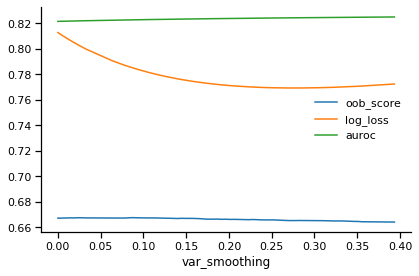

time: 1min 9s


In [11]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.1, 0.4, size=50), outfile="var_smoothing3"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
21        0.087750   0.667390  0.784890  0.822666
48        0.024178   0.667352  0.802807  0.821832
167       0.081792   0.667339  0.786170  0.822597
74        0.023798   0.667339  0.802946  0.821827
40        0.024416   0.667327  0.802719  0.821836
42        0.089039   0.667327  0.784623  0.822681
22        0.089603   0.667327  0.784507  0.822687
176       0.092725   0.667301  0.783875  0.822722
41        0.012735   0.667289  0.807224  0.821657
19        0.028930   0.667276  0.801096  0.821903
     var_smoothing  oob_score  log_loss     auroc
37        0.274353   0.665093  0.769150  0.824251
127       0.278372   0.665093  0.769151  0.824277
131       0.273695   0.665093  0.769151  0.824247
111       0.282121   0.665156  0.769159  0.824300
49        0.269499   0.665105  0.769162  0.824220
6         0.269297   0.665105  0.769163  0.824219
8         0.269089   0.665131  0.769164  0.824218
13        0.287113   0.665143  0.769183  0.824331


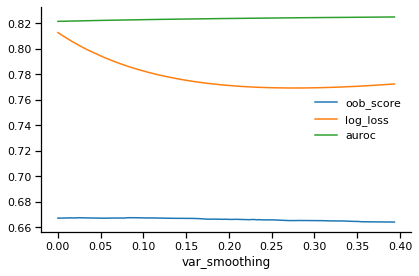

time: 1min 8s


In [12]:
tune_var_smoothing(
    search_space=np.random.uniform(0.01, 0.25, size=50), outfile="var_smoothing4"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
232       0.084951   0.667479  0.785483  0.822634
21        0.087750   0.667390  0.784890  0.822666
224       0.083116   0.667390  0.785879  0.822612
244       0.092011   0.667378  0.784018  0.822714
201       0.081968   0.667352  0.786131  0.822599
48        0.024178   0.667352  0.802807  0.821832
167       0.081792   0.667339  0.786170  0.822597
74        0.023798   0.667339  0.802946  0.821827
22        0.089603   0.667327  0.784507  0.822687
40        0.024416   0.667327  0.802719  0.821836
     var_smoothing  oob_score  log_loss     auroc
37        0.274353   0.665093  0.769150  0.824251
127       0.278372   0.665093  0.769151  0.824277
131       0.273695   0.665093  0.769151  0.824247
111       0.282121   0.665156  0.769159  0.824300
49        0.269499   0.665105  0.769162  0.824220
6         0.269297   0.665105  0.769163  0.824219
8         0.269089   0.665131  0.769164  0.824218
13        0.287113   0.665143  0.769183  0.824331


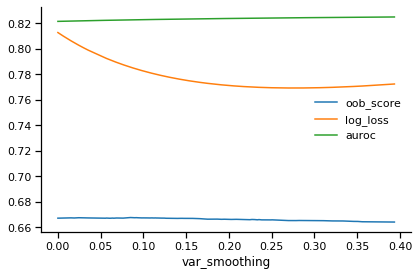

time: 1min 8s


In [13]:
tune_var_smoothing(
    search_space=np.random.uniform(0.05, 0.15, size=50), outfile="var_smoothing5"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
232       0.084951   0.667479  0.785483  0.822634
284       0.085200   0.667479  0.785429  0.822637
282       0.086688   0.667441  0.785113  0.822654
21        0.087750   0.667390  0.784890  0.822666
224       0.083116   0.667390  0.785879  0.822612
244       0.092011   0.667378  0.784018  0.822714
276       0.024788   0.667365  0.802583  0.821841
266       0.088531   0.667365  0.784728  0.822675
48        0.024178   0.667352  0.802807  0.821832
201       0.081968   0.667352  0.786131  0.822599
     var_smoothing  oob_score  log_loss     auroc
37        0.274353   0.665093  0.769150  0.824251
127       0.278372   0.665093  0.769151  0.824277
131       0.273695   0.665093  0.769151  0.824247
111       0.282121   0.665156  0.769159  0.824300
49        0.269499   0.665105  0.769162  0.824220
6         0.269297   0.665105  0.769163  0.824219
8         0.269089   0.665131  0.769164  0.824218
13        0.287113   0.665143  0.769183  0.824331


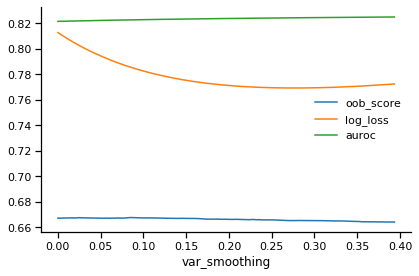

time: 1min 8s


In [14]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.01, 0.25, size=50), outfile="var_smoothing6"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
284       0.085200   0.667479  0.785429  0.822637
232       0.084951   0.667479  0.785483  0.822634
282       0.086688   0.667441  0.785113  0.822654
21        0.087750   0.667390  0.784890  0.822666
224       0.083116   0.667390  0.785879  0.822612
244       0.092011   0.667378  0.784018  0.822714
276       0.024788   0.667365  0.802583  0.821841
266       0.088531   0.667365  0.784728  0.822675
201       0.081968   0.667352  0.786131  0.822599
48        0.024178   0.667352  0.802807  0.821832
     var_smoothing  oob_score  log_loss     auroc
345       0.275800   0.665029  0.769149  0.824260
332       0.275525   0.665042  0.769149  0.824258
37        0.274353   0.665093  0.769150  0.824251
127       0.278372   0.665093  0.769151  0.824277
131       0.273695   0.665093  0.769151  0.824247
329       0.278999   0.665105  0.769152  0.824281
111       0.282121   0.665156  0.769159  0.824300
49        0.269499   0.665105  0.769162  0.824220


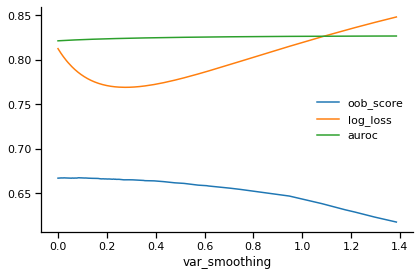

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
284       0.085200   0.667479  0.785429  0.822637
232       0.084951   0.667479  0.785483  0.822634
282       0.086688   0.667441  0.785113  0.822654
224       0.083116   0.667390  0.785879  0.822612
21        0.087750   0.667390  0.784890  0.822666
244       0.092011   0.667378  0.784018  0.822714
276       0.024788   0.667365  0.802583  0.821841
266       0.088531   0.667365  0.784728  0.822675
48        0.024178   0.667352  0.802807  0.821832
201       0.081968   0.667352  0.786131  0.822599
     var_smoothing  oob_score  log_loss     auroc
345       0.275800   0.665029  0.769149  0.824260
332       0.275525   0.665042  0.769149  0.824258
37        0.274353   0.665093  0.769150  0.824251
127       0.278372   0.665093  0.769151  0.824277
131       0.273695   0.665093  0.769151  0.824247
329       0.278999   0.665105  0.769152  0.824281
111       0.282121   0.665156  0.769159  0.824300
49        0.269499   0.665105  0.769162  0.824220


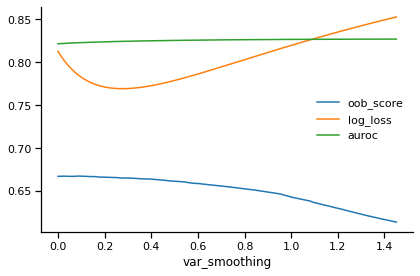

time: 2min 16s


In [15]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.01, 1.5, size=50), outfile="var_smoothing7"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.01, 1.5, size=50), outfile="var_smoothing8"
)

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
284       0.085200   0.667479  0.785429  0.822637
232       0.084951   0.667479  0.785483  0.822634
282       0.086688   0.667441  0.785113  0.822654
433       0.085368   0.667441  0.785393  0.822639
224       0.083116   0.667390  0.785879  0.822612
21        0.087750   0.667390  0.784890  0.822666
244       0.092011   0.667378  0.784018  0.822714
440       0.083329   0.667378  0.785833  0.822615
276       0.024788   0.667365  0.802583  0.821841
266       0.088531   0.667365  0.784728  0.822675
     var_smoothing  oob_score  log_loss     auroc
345       0.275800   0.665029  0.769149  0.824260
332       0.275525   0.665042  0.769149  0.824258
37        0.274353   0.665093  0.769150  0.824251
127       0.278372   0.665093  0.769151  0.824277
131       0.273695   0.665093  0.769151  0.824247
329       0.278999   0.665105  0.769152  0.824281
111       0.282121   0.665156  0.769159  0.824300
49        0.269499   0.665105  0.769162  0.824220


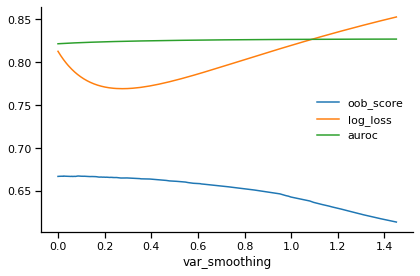

  0%|          | 0/50 [00:00<?, ?it/s]

     var_smoothing  oob_score  log_loss     auroc
284       0.085200   0.667479  0.785429  0.822637
232       0.084951   0.667479  0.785483  0.822634
433       0.085368   0.667441  0.785393  0.822639
282       0.086688   0.667441  0.785113  0.822654
465       0.086601   0.667416  0.785131  0.822653
224       0.083116   0.667390  0.785879  0.822612
21        0.087750   0.667390  0.784890  0.822666
244       0.092011   0.667378  0.784018  0.822714
440       0.083329   0.667378  0.785833  0.822615
276       0.024788   0.667365  0.802583  0.821841
     var_smoothing  oob_score  log_loss     auroc
345       0.275800   0.665029  0.769149  0.824260
332       0.275525   0.665042  0.769149  0.824258
37        0.274353   0.665093  0.769150  0.824251
127       0.278372   0.665093  0.769151  0.824277
131       0.273695   0.665093  0.769151  0.824247
496       0.273495   0.665105  0.769151  0.824246
329       0.278999   0.665105  0.769152  0.824281
479       0.279536   0.665093  0.769153  0.824284


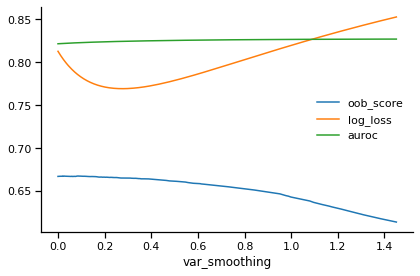

time: 2min 17s


In [16]:
tune_var_smoothing(
    search_space=loguniform.rvs(0.015, 0.4, size=50), outfile="var_smoothing9"
)
tune_var_smoothing(
    search_space=np.random.uniform(0.016, 0.399, size=50), outfile="var_smoothing10"
)

In [17]:
files = [
    "var_smoothing1.feather",
    "var_smoothing2.feather",
    "var_smoothing3.feather",
    "var_smoothing4.feather",
    "var_smoothing5.feather",
    "var_smoothing6.feather",
    "var_smoothing7.feather",
    "var_smoothing8.feather",
    "var_smoothing9.feather",
    "var_smoothing10.feather",
]
df = pd.concat(
    [pd.read_feather(f"{DATA_OUT_FOLDER}/{file}") for file in files],
    axis="rows",
)

time: 82.3 ms


<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

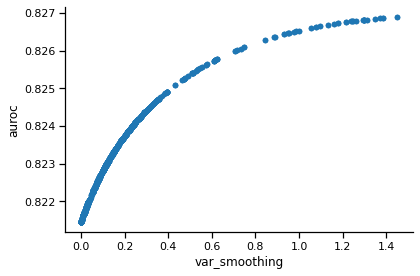

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

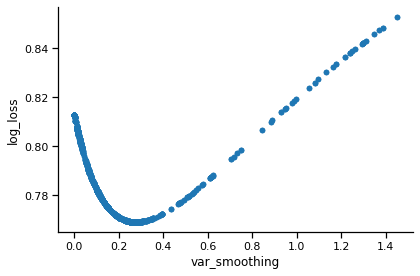

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

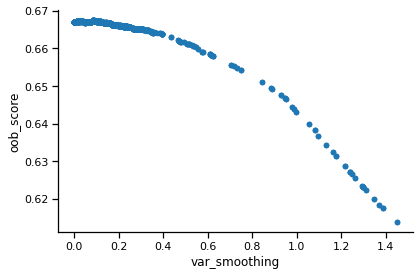

time: 565 ms


In [18]:
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    df.sort_values(by="var_smoothing").plot(x="var_smoothing", y=metric, kind="scatter")
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [19]:
# best
df = df.drop_duplicates()
df.loc[df.log_loss == df.log_loss.min()]
df.loc[df.oob_score == df.oob_score.max()].sort_values(by="log_loss", ascending=True)
df.loc[df.auroc == df.auroc.max()]

,var_smoothing,oob_score,log_loss,auroc
307,0.2758,0.665029,0.769149,0.82426


,var_smoothing,oob_score,log_loss,auroc
120,0.085200,0.667479,0.785429,0.822637
87,0.084951,0.667479,0.785483,0.822634


,var_smoothing,oob_score,log_loss,auroc
399,1.450949,0.613834,0.852644,0.82689


time: 23.4 ms


In [20]:
# next best
df.sort_values(by="log_loss", ascending=True).head(11).tail(10)
df.sort_values(by="oob_score", ascending=False).head(12).tail(10)
df.sort_values(by="auroc", ascending=False).head(11).tail(10)

,var_smoothing,oob_score,log_loss,auroc
306,0.275525,0.665042,0.769149,0.824258
45,0.274353,0.665093,0.769150,0.824251
130,0.278372,0.665093,0.769151,0.824277
128,0.273695,0.665093,0.769151,0.824247
385,0.273495,0.665105,0.769151,0.824246
309,0.278999,0.665105,0.769152,0.824281
392,0.279536,0.665093,0.769153,0.824284
393,0.281655,0.665143,0.769158,0.824297
131,0.282121,0.665156,0.769159,0.824300
44,0.269499,0.665105,0.769162,0.824220


,var_smoothing,oob_score,log_loss,auroc
121,0.086688,0.667441,0.785113,0.822654
168,0.085368,0.667441,0.785393,0.822639
179,0.086601,0.667416,0.785131,0.822653
86,0.083116,0.667390,0.785879,0.822612
10,0.087750,0.667390,0.784890,0.822666
91,0.092011,0.667378,0.784018,0.822714
165,0.083329,0.667378,0.785833,0.822615
68,0.024788,0.667365,0.802583,0.821841
123,0.088531,0.667365,0.784728,0.822675
85,0.081968,0.667352,0.786131,0.822599


,var_smoothing,oob_score,log_loss,auroc
349,1.385209,0.617617,0.848274,0.826861
397,1.369811,0.618493,0.847229,0.826853
396,1.345837,0.620003,0.845583,0.826841
395,1.309320,0.622326,0.843037,0.826819
394,1.297068,0.623215,0.842172,0.826812
348,1.295941,0.623228,0.842092,0.826811
392,1.295767,0.623228,0.842080,0.826811
391,1.292290,0.623507,0.841833,0.826809
390,1.262397,0.625703,0.839695,0.826788
389,1.247699,0.626604,0.838631,0.826778


time: 14.1 ms


<AxesSubplot:xlabel='var_smoothing'>

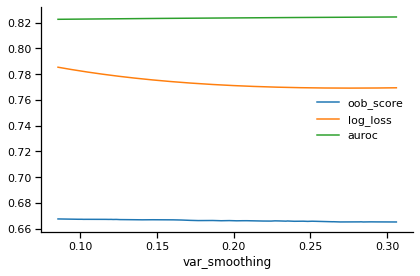

<AxesSubplot:xlabel='var_smoothing', ylabel='auroc'>

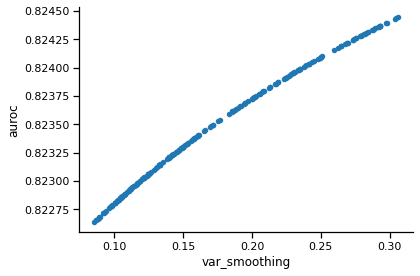

<AxesSubplot:xlabel='var_smoothing', ylabel='log_loss'>

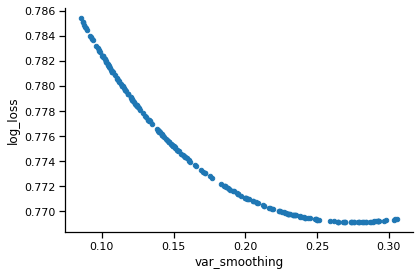

<AxesSubplot:xlabel='var_smoothing', ylabel='oob_score'>

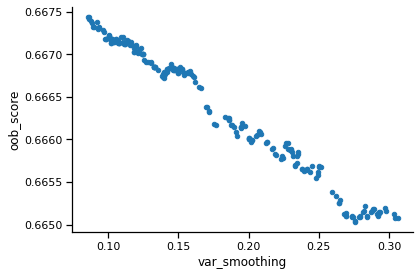

time: 724 ms


In [21]:
good_df = df.loc[df.var_smoothing < 1.25]
good_df = good_df.loc[
    good_df.auroc < 0.826778
]  # the top auroc models are probably overfit
# get the spots between the two observed training optima
good_df = good_df.loc[good_df.log_loss < 0.785429]
good_df = good_df.loc[good_df.oob_score > 0.665029]

# plot
good_df.sort_values(by="var_smoothing").plot(x="var_smoothing")
plt.legend(frameon=False)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()
for metric in ("auroc", "log_loss", "oob_score"):
    # plot
    good_df.sort_values(by="var_smoothing").plot(
        x="var_smoothing", y=metric, kind="scatter"
    )
    plt.legend(frameon=False)
    sns.despine(top=True, right=True)
    plt.tight_layout()
    plt.show()

In [22]:
# better bests
good_df.loc[good_df.log_loss == good_df.log_loss.min()]
good_df.loc[good_df.oob_score == good_df.oob_score.max()].sort_values(
    by="log_loss", ascending=True
)
good_df.loc[good_df.auroc == good_df.auroc.max()]

,var_smoothing,oob_score,log_loss,auroc
307,0.2758,0.665029,0.769149,0.82426


,var_smoothing,oob_score,log_loss,auroc
121,0.086688,0.667441,0.785113,0.822654
168,0.085368,0.667441,0.785393,0.822639


,var_smoothing,oob_score,log_loss,auroc
140,0.30611,0.66508,0.769392,0.824445


time: 19.2 ms


In [23]:
a = good_df.loc[good_df.log_loss == good_df.log_loss.min()].var_smoothing.iloc[0]
b = (
    good_df.loc[good_df.oob_score == good_df.oob_score.max()]
    .sort_values(by="log_loss", ascending=True)
    .var_smoothing.iloc[0]
)
oob_loss_avg_var_smoothing = np.mean([a, b])
oob_loss_avg_var_smoothing

0.1812436618470557

time: 4.97 ms


In [24]:
final_gnb = BaggingClassifier(
    base_estimator=GaussianNB(var_smoothing=oob_loss_avg_var_smoothing),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
)
_ = gc_collect()

time: 140 ms


In [25]:
final_gnb.fit(data.loc[:, gnb_features], labels.valence)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


BaggingClassifier(base_estimator=GaussianNB(var_smoothing=0.1812436618470557),
                  n_estimators=50, n_jobs=-1, oob_score=True, random_state=2022,
                  verbose=1)

time: 827 ms


In [26]:
final_gnb.oob_score_
log_loss(y_true, final_gnb.predict_proba(data.loc[:, gnb_features]))
roc_auc_score(
    y_true, final_gnb.predict_proba(data.loc[:, gnb_features]), multi_class="ovo"
)

0.6662096804904984

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.2s finished


0.772321225988232

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.1s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished


0.8235768117175728

time: 1.01 s


# Discussion

There looks to be a sweet spot in training loss. We chose a balance between training log loss and OOB accuracy.

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [27]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 700.9747822284698 s
time: 101 ms


[^top](#Contents)